In [ ]:
from ngsolve import *
from netgen.geom2d import *
from nonlin_arnoldis import *
from ngsolve.webgui import Draw
import numpy as np
from time import sleep, time
from numpy import array,sqrt,loadtxt
from netgen.occ import *
import matplotlib.pyplot as plt
import scipy as sc
from matplotlib.pyplot import *
from fem1d import geo1d     
%matplotlib widget              # pip install ipympl to use that

In [2]:
def creategeo(innershape="circle",outershape="circle",R=1,R2 = 0.9):
    if outershape == "circle":
        outerobj = Circle(center, R).Face()
        outerobj.edges.name = 'Gamma'
        outerobj.faces.name ='inner'

    elif outershape == "rectangle":
        outerobj = MoveTo(-1,-1).Rectangle(2*R,2*R).Face()
        outerobj.edges.name = 'Gamma'
        outerobj.faces.name ='inner'


    if innershape == "circle":
        innerobj = Circle(center2, R2).Face()
        innerobj.edges.name = 'inner_boundary'
    elif innershape == "rectangle":
        innerobj = MoveTo(-R2,-R2).Rectangle(2*R2,2*R2).Face()
        innerobj.edges.name = 'inner_boundary'


    else:
        return OCCGeometry(outerobj, dim=2)
    
    return OCCGeometry(outerobj-innerobj,dim=2)

In [3]:
def create_1d_matrices(L,order_1d, maxh_1d):
    mesh1d = Mesh(geo1d(0,L).GenerateMesh(maxh=maxh_1d))
    fes1d = H1(mesh1d,order=order_1d,complex=True)

    u,u_ = fes1d.TnT()

    fem1d_mass_surf = array(BilinearForm(u*u_*ds('left')).Assemble().mat.ToDense())

    fem1d_mass = array(BilinearForm(u*u_*dx).Assemble().mat.ToDense())
    fem1d_mass_x = array(BilinearForm(x*u*u_*dx).Assemble().mat.ToDense())
    fem1d_mass_xx = array(BilinearForm(x*x*u*u_*dx).Assemble().mat.ToDense())

    fem1d_drift = array(BilinearForm(grad(u)*u_*dx).Assemble().mat.ToDense())
    fem1d_drift_x = array(BilinearForm(x*grad(u)*u_*dx).Assemble().mat.ToDense())
    fem1d_drift_xx = array(BilinearForm(x*x*grad(u)*u_*dx).Assemble().mat.ToDense())

    fem1d_laplace = array(BilinearForm(grad(u)*grad(u_)*dx).Assemble().mat.ToDense())
    fem1d_laplace_x = array(BilinearForm(x*grad(u)*grad(u_)*dx).Assemble().mat.ToDense())
    fem1d_laplace_xx = array(BilinearForm(x*x*grad(u)*grad(u_)*dx).Assemble().mat.ToDense())
    
    return fem1d_mass,fem1d_mass_x,fem1d_mass_xx, fem1d_drift, fem1d_drift_x, fem1d_drift_xx, fem1d_laplace, fem1d_laplace_x, fem1d_laplace_xx, fem1d_mass_surf


In [4]:
def solve_evp(
    maxh = 0.05,   #mesh-size
    maxh_1d = 0.002, #mesh-size for 1d mesh
    order =  1,  #fem order
    order_1d = 1,
    L = 0.2,  #length of radial part
    center = (0.,0),    #center of circle
    center2 = (+0.,0.0), #center of inner circle
    center_scaling = (0,0),
    innershape = "circle",     #rectangle|none
    outershape = "rectangle",   #rectangle
    R = 1,           #radius of circle
    R2 = 0.9,            #radius of inner circle
    alpha = 20.0,
    gamma = 0,
    w_shifts = [1+0.5j,3+0.5j],
    nefs = 0,
    nevals = 100,
    krylovdim = 300
):

    fem1d_mass,fem1d_mass_x,fem1d_mass_xx, fem1d_drift, fem1d_drift_x, fem1d_drift_xx, fem1d_laplace, fem1d_laplace_x, fem1d_laplace_xx, fem1d_mass_surf = create_1d_matrices(L,order_1d,maxh_1d)
    geo =  creategeo(innershape,outershape,R,R2)
    
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    mesh.Curve(2*order)
    Draw(mesh)
    
    Gamma = mesh.Boundaries('Gamma')

    fes_int = H1(mesh,order=order,complex=True)
    fes_surf = H1(mesh,order=order,complex=True,definedon=Gamma)
    N = len(fem1d_mass)
    
    print("N = {}".format(N))
    fes = ProductSpace(fes_int,*( (N-1)*[fes_surf]))

    print("ndof primal: {}".format(fes.ndof))

    
    n = specialcf.normal(2) 
    v = CoefficientFunction((x-center_scaling[0],y-center_scaling[1]))   
    
    ds_g = ds(definedon=Gamma)
    p,q = fes.TnT()


    p_int,q_int = p[0],q[0]
    ## original coefficient (-i\omega)^0
    W0 =(
             grad(p_int)*grad(q_int)*dx
             +sum(fem1d_laplace[i,j]*1/(n*v)*p[j]*q[i]*ds_g 
               for i in range(N) for j in range(N) if abs(fem1d_laplace[i,j])>0)
             +sum(fem1d_laplace_x[i,j]*2/(n*v)*p[j]*q[i]*ds_g 
               for i in range(N) for j in range(N) if abs(fem1d_laplace_x[i,j])>0)
             +sum(fem1d_laplace_xx[i,j]*1/(n*v)*p[j]*q[i]*ds_g 
               for i in range(N) for j in range(N) if abs(fem1d_laplace_xx[i,j])>0)
             -sum(fem1d_mass[i,j]*1/(4*n*v)*p[j]*q[i]*ds_g 
               for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
             -sum(fem1d_drift[i,j]*1/(n*v)*v*p[i].Trace().Deriv()*q[j]*ds_g                    
               for i in range(N) for j in range(N) if abs(fem1d_drift[i,j])>0)
             -sum(fem1d_drift_x[i,j]*1/(n*v)*v*p[i].Trace().Deriv()*q[j]*ds_g 
                for i in range(N) for j in range(N) if abs(fem1d_drift_x[i,j])>0)     
             -sum(fem1d_drift[i,j]*1/(n*v)*v*p[j]*q[i].Trace().Deriv()*ds_g               #T (indices swapped)
               for i in range(N) for j in range(N) if abs(fem1d_drift[i,j])>0)          
             -sum(fem1d_drift_x[i,j]*1/(n*v)*v*p[j]*q[i].Trace().Deriv()*ds_g               #T
                for i in range(N) for j in range(N) if abs(fem1d_drift_x[i,j])>0)
             -sum(fem1d_mass[i,j]*1/(2*n*v)*v*p[j].Trace().Deriv()*q[i]*ds_g 
               for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
             -sum(fem1d_mass[i,j]*1/(2*n*v)*v*p[j]*q[i].Trace().Deriv()*ds_g 
               for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)    
             +sum(fem1d_mass[i,j]*(v*v)/(n*v)*p[j].Trace().Deriv()*q[i].Trace().Deriv()*ds_g 
               for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0) 
             -sum(fem1d_mass_surf[i,j]*1/(2*n*v)*p[j]*q[i]*ds_g   
               for i in range(N) for j in range(N) if abs(fem1d_mass_surf[i,j])>0)
            )

    ## original coefficient \alpha / (\gamma-i\omega+\alpha)
    W1 =(sum(-fem1d_laplace[i,j]*1/(n*v)*p[j]*q[i]*ds_g                                   #h6
               for i in range(N) for j in range(N) if abs(fem1d_laplace[i,j])>0))


    ## original coefficient \alpha / (\gamma-i\omega)
    W2 =(
             sum(fem1d_laplace_xx[i,j]*1/(n*v)*p[j]*q[i]*ds_g                                   #h1
               for i in range(N) for j in range(N) if abs(fem1d_laplace_xx[i,j])>0)
             -sum(fem1d_mass[i,j]*1/(4*n*v)*p[j]*q[i]*ds_g                                         #h1
               for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
             -sum(fem1d_drift_x[i,j]*1/(n*v)*v*p[i].Trace().Deriv()*q[j]*ds_g                          #h1
               for i in range(N) for j in range(N) if abs(fem1d_drift_x[i,j])>0)
             -sum(fem1d_drift_x[i,j]*1/(n*v)*p[j]*v*q[i].Trace().Deriv()*ds_g                #T            #h1
               for i in range(N) for j in range(N) if abs(fem1d_drift_x[i,j])>0)
             -sum(fem1d_mass[i,j]*1/(2*n*v)*v*p[j].Trace().Deriv()*q[i]*ds_g                 #h1
               for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
             -sum(fem1d_mass[i,j]*1/(2*n*v)*v*p[j]*q[i].Trace().Deriv()*ds_g                 #h1
               for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
             +sum(fem1d_mass[i,j]*(v*v)/(n*v)*p[j].Trace().Deriv()*q[i].Trace().Deriv()*ds_g             #h1
               for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
    )

    ## original coefficient (-i\omega)^2

    W3 = (
            q_int*p_int*dx
            +sum(fem1d_mass[i,j]*(n*v)*p[j]*q[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
            +sum(2*fem1d_mass_x[i,j]*(n*v)*p[j]*q[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass_x[i,j])>0)
            +sum(fem1d_mass_xx[i,j]*(n*v)*p[j]*q[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass_xx[i,j])>0)    
    )

    ## original coefficient (-i\omega)^2\alpha/(\gamma-i\omega)

    W4 = (
            sum(fem1d_mass[i,j]*(n*v)*p[j]*q[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
            +sum(4*fem1d_mass_x[i,j]*(n*v)*p[j]*q[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass_x[i,j])>0)
            +sum(3*fem1d_mass_xx[i,j]*(n*v)*p[j]*q[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass_xx[i,j])>0)    
    )
    ## original coefficient (-i\omega)^2\alpha^2/(\gamma-i\omega)^2

    W5 = (
            sum(2*fem1d_mass_x[i,j]*(n*v)*p[j]*q[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass_x[i,j])>0)
            +sum(3*fem1d_mass_xx[i,j]*(n*v)*p[j]*q[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass_xx[i,j])>0)    
    )


    ## original coefficient (-i\omega)^2\alpha^3/(\gamma-i\omega)^3
    W6 = (
            sum(fem1d_mass_xx[i,j]*(n*v)*p[j]*q[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass_xx[i,j])>0)    
    )
    if abs(gamma)>0:

        M0 = BilinearForm(
            (alpha*gamma**3+gamma**4)*W0+alpha*gamma**3*W1+(alpha**2*gamma**2+alpha*gamma**3)*W2
        ).Assemble().mat
        M1 = BilinearForm(
            (3*alpha*gamma**2+4*gamma**3)*W0+3*alpha*gamma**2*W1+(2*alpha**2*gamma+3*alpha*gamma**2)*W2
        ).Assemble().mat
        M2 = BilinearForm((3*alpha*gamma+6*gamma**2)*W0
              +3*alpha*gamma*W1
              +(alpha**2+3*alpha*gamma)*W2
              +(gamma**4+alpha*gamma**3)*W3
              +(alpha**2*gamma**2+alpha*gamma**3)*W4
              +(alpha**3*gamma+alpha**2*gamma**2)*W5
              +(alpha**4+alpha**3*gamma)*W6).Assemble().mat
        M3 = BilinearForm((alpha+4*gamma)*W0
              +alpha*W1
              +alpha*W2
              +(3*alpha*gamma**2+4*gamma**3)*W3
              +(2*alpha**2*gamma+3*alpha*gamma**2)*W4
              +(alpha**3+2*alpha**2*gamma)*W5
              +alpha**3*W6).Assemble().mat
        M4 = BilinearForm(W0
              +(3*alpha*gamma+6*gamma**2)*W3
              +(alpha**2+3*alpha*gamma)*W4
              +alpha**2*W5).Assemble().mat
        M5 = BilinearForm((alpha+4*gamma)*W3+alpha*W4).Assemble().mat

        M6 = BilinearForm(W3).Assemble().mat
        matlist = [M0,M1,M2,M3,M4,M5,M6]

    else:
        M2 = BilinearForm(alpha**2*W2+alpha**4*W6).Assemble().mat
        M3 = BilinearForm(alpha*W0
              +alpha*W1
              +alpha*W2
              +alpha**3*W5
              +alpha**3*W6).Assemble().mat
        M4 = BilinearForm(W0
              +alpha**2*W4
              +alpha**2*W5).Assemble().mat
        M5 = BilinearForm(alpha*W3+alpha*W4).Assemble().mat

        M6 = BilinearForm(W3).Assemble().mat
        matlist = [M2,M3,M4,M5,M6]
        
    gf = GridFunction(fes,multidim=nefs)



    lams = []
    for shift in w_shifts:       ###shift is now for s=-1j*omega
        print("shift = {}".format(shift))
        lams.append(1j*np.array(PolyArnoldiSolver(matlist,-1j*shift,krylovdim,nevals=nevals,vecs=list(gf.vecs),inversetype='sparsecholesky',freedofs=fes.FreeDofs())))
    return lams


In [5]:
def plot_results(lams, alpha, gamma, mu, w_shifts, R2, reference = True): 
    figure()
    print("gamma =", gamma, "alpha =", alpha)
    for shift,lam in zip(w_shifts,lams):
        plot(lam.real,lam.imag,'x',label='res, shift = {}'.format(shift))
        plot(shift.real,shift.imag, 'o',label ="shift {}".format(shift))
    ts = np.arange(-100,100,0.1)

    ess_spec_p = 1j*(1/2*(1j*ts-gamma-alpha)+np.sqrt(1/4*(1j*ts-gamma-alpha)**2+1j*ts*gamma))
    ess_spec_m = 1j*(1/2*(1j*ts-gamma-alpha)-np.sqrt(1/4*(1j*ts-gamma-alpha)**2+1j*ts*gamma))
    plt.plot(ess_spec_p.real,ess_spec_p.imag,label='ess spec +')
    plt.plot(ess_spec_m.real,ess_spec_m.imag,label='ess spec -')


    #mu= 1j+1    #1j means orthogonal scaling


    ess_spec_p = 1j*(gamma*mu*ts-gamma-alpha)/(1-mu*ts)
    ess_spec_m = 1j*(gamma*np.conj(mu)*ts-gamma-alpha)/(1-np.conj(mu)*ts)
    plt.plot(ess_spec_p.real,ess_spec_p.imag,label='ess spec +')
    plt.plot(ess_spec_m.real,ess_spec_m.imag,label='ess spec -')


    if reference:
        #load reference resonances from file
        loaded=loadtxt('dhankel_1_zeros.out')
        ref=(loaded[:,0]+1j*loaded[:,1])/R2

        plt.plot(ref.real,ref.imag,'.k',label='reference')

    plt.plot(np.linspace(-5,5,100),np.zeros(100),'--r',linewidth=0.5, label='real axis')
    plt.xlim((-1,10))
    plt.ylim((-10,1))
    #plt.legend()
    plt.show()

used dof inconsistency
(silence this warning by setting BilinearForm(...check_unused=False) )


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

N = 67
ndof primal: 40897
shift = (1-1j)
shift = (3+0.5j)
shift = (5+0.5j)
shift = (2-3j)
maxh =  0.1 maxh_1d =  0.03 order =   2 order_1d =  2 L =  1.0 center =  (0.0, 0) center2 =  (0.0, 0.0) center_scaling =  (0.4, 0.4) innershape =  none outershape =  rectangle R =  1 R2 =  0.9 alpha =  10.0 gamma =  2.0 w_shifts =  [(1-1j), (3+0.5j), (5+0.5j), (2-3j)] nefs =  0 nevals =  40 krylovdim =  100
gamma = 2.0 alpha = 10.0


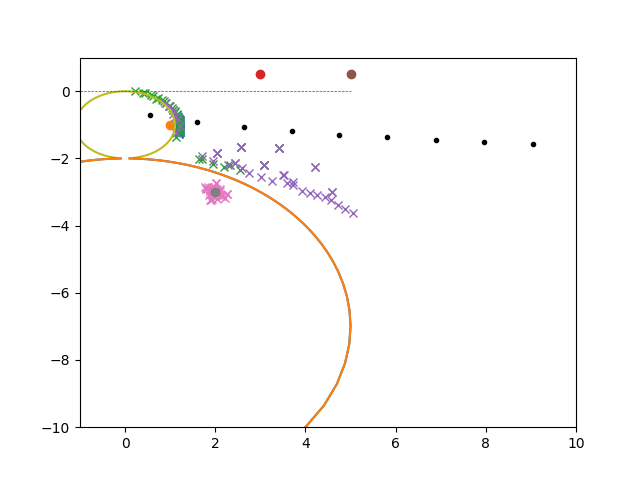

In [6]:
maxh = 0.1   #mesh-size
maxh_1d = 0.03 #mesh-size for 1d mesh
order =  2  #fem order
order_1d = 2
L = 1.0  #length of radial part
center = (0.,0)    #center of circle
center2 = (+0.,0.0) #center of inner circle
center_scaling = (0.4,0.4)
innershape = "none"     #rectangle|none
outershape = "rectangle"   #rectangle
R = 1           #radius of circle
R2 = 0.9            #radius of inner circle
alpha = 10.0
gamma = 2.0
w_shifts = [1-1j,3+0.5j, 5+0.5j, 2-3j] #5-3j, 8-3j, 5-10j, 8-10j]
nefs = 0
nevals = 40
krylovdim = 100

lams = solve_evp(
    maxh = maxh,
    maxh_1d = maxh_1d,
    order =  order,
    order_1d = order_1d,
    L = L,
    center = center,
    center2 = center2,
    center_scaling = center_scaling,
    innershape = innershape,
    outershape = outershape,
    R = R,
    R2 = R2,
    alpha = alpha,
    gamma = gamma,
    w_shifts = w_shifts,
    nefs = nefs,
    nevals = nevals,
    krylovdim = krylovdim
)
print(
    "maxh = ",maxh,
    "maxh_1d = ",maxh_1d,
    "order =  ",order,
    "order_1d = ",order_1d,
    "L = ",L,
    "center = ",center,
    "center2 = ",center2,
    "center_scaling = ",center_scaling,
    "innershape = ",innershape,
    "outershape = ",outershape,
    "R = ",R,
    "R2 = ",R2,
    "alpha = ",alpha,
    "gamma = ",gamma,
    "w_shifts = ",w_shifts,
    "nefs = ",nefs,
    "nevals = ",nevals,
    "krylovdim = ",krylovdim)

mu = 1j

plot_results(lams, alpha, gamma, mu, w_shifts, R2, reference = True)

